In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import DoubleWell
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [6]:
import mdtraj
import io
import nglview
import pyemma

In [7]:
paper_dir = "/Users/noe/data/open_projects/boltzmann_generators/coarsegraining_KL/"

Villin
---

In [8]:
# Define coordinates
cart_indices = np.array([6, 8, 10, 14])  # N, Ca, C, Cb
ic_indices = np.array([[7, 6, 8, 14],
                       [9, 8, 6, 14],
                       [15, 14, 8, 6],
                       [11, 10, 8, 6],
                       [12, 10, 8, 11],
                       [13, 10, 8, 11],
                       [4, 6, 8, 14],
                       [1, 4, 6, 8],
                       [5, 4, 6, 1],
                       [3, 1, 4, 6],
                       [2, 1, 4, 3],
                       [0, 1, 4, 3],
                       [16, 14, 8, 6],
                       [18, 16, 14, 8],
                       [17, 16, 14, 18],
                       [19, 18, 16, 14],
                       [20, 18, 16, 19],
                       [21, 18, 16, 19]])

In [9]:
folded = mdtraj.load('/Users/noe/data/open_projects/md_data/Villin/2F4K-0-protein_fixed_noH.pdb')
top = folded.topology

/Users/noe/anaconda/lib/python3.5/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.5, you have 2.5.3.
  .format(latest=latest, current=current), category=UserWarning)


In [10]:
top

<mdtraj.Topology with 1 chains, 35 residues, 287 atoms, 290 bonds at 0x1a3696ef98>

In [11]:
view = nglview.show_mdtraj(folded)
view

NGLWidget()

In [12]:
traj = mdtraj.load('/Users/noe/data/open_projects/md_data/Villin/2F4K-0-protein_all_every5.dcd', top=top)

In [13]:
traj = mdtraj.Trajectory(10*traj.xyz, top)
#traj.superpose(traj[0], atom_indices=cart_indices)

In [14]:
idx_backbone = top.select('name C CA N')
top_backbone = top.subset(idx_backbone)
traj_backbone = mdtraj.Trajectory(traj.xyz[:, idx_backbone, :], top_backbone)

In [15]:
view = nglview.show_mdtraj(traj_backbone[::10])
view

NGLWidget(count=12559)

In [16]:
featurizer = pyemma.coordinates.featurizer(top)
featurizer.add_distances_ca()

In [17]:
traj_featurized = 10.0 * pyemma.coordinates.load('/Users/noe/data/open_projects/md_data/Villin/2F4K-0-protein_all_every5.dcd', 
                                                 features=featurizer)

In [18]:
tica_obj = pyemma.coordinates.tica(data=traj_featurized, lag=10, dim=3)
tics = tica_obj.get_output()[0]

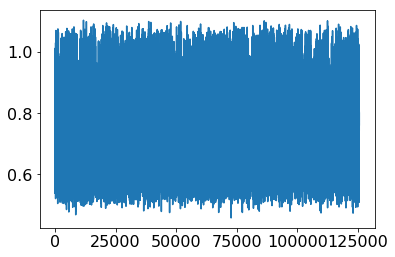

In [19]:
plt.plot(traj_featurized[:, 0])

(<matplotlib.figure.Figure at 0x1a38bd2f28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a3b599cf8>)

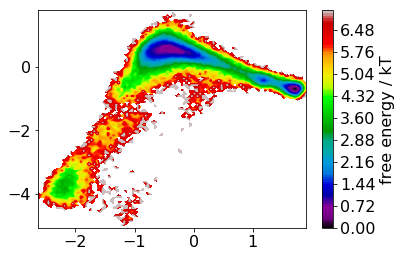

In [20]:
pyemma.plots.plot_free_energy(tics[:, 0], tics[:, 1])

Boltzmann Generator
-----

In [21]:
batchsize_ML = 2048
temperature = 1.0
explore = 1.0

In [22]:
xyzflat = traj_backbone.xyz.reshape((traj_backbone.xyz.shape[0], -1))

In [23]:
channels = np.concatenate([np.tile([0, 0, 0, 1, 1, 1], top_backbone.n_atoms//2), [0, 0, 0]])
#RPRZRPRZRPRZRPRZRPRZRPRZRPR
bg = invnet(xyzflat.shape[1], 'RZRZRZRZRZRZRRZRR', energy_model=None, channels=None,#channels, 
            nl_layers=6, nl_hidden=[100, 100, 100, 100, 100],
            nl_layers_scale=6, nl_hidden_scale=[100, 10, 10, 10, 100], 
            nl_activation='relu', nl_activation_scale='tanh', 
            whiten=xyzflat)

W<RZRZRZRZRZRZRRZRR>
W 315 0 0
< 315 0 0
R 158 157 0
Z 158 157 0
R 79 79 157
Z 79 79 157
R 40 39 236
Z 40 39 236
R 20 20 275
Z 20 20 275
R 10 10 295
Z 10 10 295
R 5 5 305
Z 5 5 305
R 3 2 310
R 3 2 310
Z 3 2 310
R 2 1 312
R 2 1 312
> 2 1 312
Instructions for updating:
Colocations handled automatically by placer.
27-05-19 18:34:10 tensorflow   WARNING  From /Users/noe/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [24]:
epochsZ = 2000
hists = []

In [45]:
for i in range(4):
    # repeat this 4 times!
    hist = bg.train_ML(xyzflat, lr=0.0001, epochs=epochsZ, batch_size=batchsize_ML, std=1.0, 
                       verbose=1, return_test_energies=True)
    hists.append(hist)

Epoch 0/2000 loss -1010.6127 
Epoch 1/2000 loss -995.0466 
Epoch 2/2000 loss -1009.9160 
Epoch 3/2000 loss -1010.0441 
Epoch 4/2000 loss -1006.3571 
Epoch 5/2000 loss -1007.4974 
Epoch 6/2000 loss -1007.8625 
Epoch 7/2000 loss -1009.5504 
Epoch 8/2000 loss -1011.3791 
Epoch 9/2000 loss -1006.8330 
Epoch 10/2000 loss -1009.2548 
Epoch 11/2000 loss -1009.3159 
Epoch 12/2000 loss -1014.4821 
Epoch 13/2000 loss -1014.5866 
Epoch 14/2000 loss -1013.2690 
Epoch 15/2000 loss -1004.8811 
Epoch 16/2000 loss -1013.9923 
Epoch 17/2000 loss -1008.4114 
Epoch 18/2000 loss -1014.0403 
Epoch 19/2000 loss -1007.1464 
Epoch 20/2000 loss -1016.4890 
Epoch 21/2000 loss -1010.2775 
Epoch 22/2000 loss -1013.7124 
Epoch 23/2000 loss -1011.8860 
Epoch 24/2000 loss -1014.6051 
Epoch 25/2000 loss -1014.9191 
Epoch 26/2000 loss -1009.1069 
Epoch 27/2000 loss -1006.1443 
Epoch 28/2000 loss -1009.1117 
Epoch 29/2000 loss -1015.9510 
Epoch 30/2000 loss -1013.6980 
Epoch 31/2000 loss -1012.0184 
Epoch 32/2000 loss 

Epoch 260/2000 loss -1016.0969 
Epoch 261/2000 loss -1019.6774 
Epoch 262/2000 loss -1012.3130 
Epoch 263/2000 loss -1012.0928 
Epoch 264/2000 loss -1011.5500 
Epoch 265/2000 loss -1012.5793 
Epoch 266/2000 loss -1013.0371 
Epoch 267/2000 loss -1011.7123 
Epoch 268/2000 loss -1011.6435 
Epoch 269/2000 loss -1013.9896 
Epoch 270/2000 loss -1013.8938 
Epoch 271/2000 loss -1013.6171 
Epoch 272/2000 loss -1015.6865 
Epoch 273/2000 loss -1012.5971 
Epoch 274/2000 loss -1009.5140 
Epoch 275/2000 loss -1005.5331 
Epoch 276/2000 loss -1007.5011 
Epoch 277/2000 loss -1017.1835 
Epoch 278/2000 loss -1010.8173 
Epoch 279/2000 loss -1013.4306 
Epoch 280/2000 loss -1014.3616 
Epoch 281/2000 loss -1015.9316 
Epoch 282/2000 loss -1015.3318 
Epoch 283/2000 loss -1016.6266 
Epoch 284/2000 loss -1018.8583 
Epoch 285/2000 loss -1010.6674 
Epoch 286/2000 loss -1021.1702 
Epoch 287/2000 loss -1018.2465 
Epoch 288/2000 loss -1016.8619 
Epoch 289/2000 loss -1011.9678 
Epoch 290/2000 loss -1014.1680 
Epoch 29

Epoch 517/2000 loss -1013.5212 
Epoch 518/2000 loss -1016.1284 
Epoch 519/2000 loss -1014.2925 
Epoch 520/2000 loss -1013.0959 
Epoch 521/2000 loss -1011.8907 
Epoch 522/2000 loss -1009.6873 
Epoch 523/2000 loss -1011.2859 
Epoch 524/2000 loss -1009.8824 
Epoch 525/2000 loss -1011.3466 
Epoch 526/2000 loss -1011.5261 
Epoch 527/2000 loss -1014.7208 
Epoch 528/2000 loss -1009.8265 
Epoch 529/2000 loss -1013.0460 
Epoch 530/2000 loss -1016.2585 
Epoch 531/2000 loss -1015.8334 
Epoch 532/2000 loss -1008.8989 
Epoch 533/2000 loss -1017.2300 
Epoch 534/2000 loss -1014.6593 
Epoch 535/2000 loss -1015.9671 
Epoch 536/2000 loss -1007.6531 
Epoch 537/2000 loss -1009.0310 
Epoch 538/2000 loss -1013.7879 
Epoch 539/2000 loss -1010.8208 
Epoch 540/2000 loss -1012.0174 
Epoch 541/2000 loss -1015.7438 
Epoch 542/2000 loss -1013.3970 
Epoch 543/2000 loss -1016.3833 
Epoch 544/2000 loss -1009.9647 
Epoch 545/2000 loss -1014.4649 
Epoch 546/2000 loss -1009.9341 
Epoch 547/2000 loss -1009.7729 
Epoch 54

Epoch 774/2000 loss -1011.8394 
Epoch 775/2000 loss -1017.0713 
Epoch 776/2000 loss -1017.2511 
Epoch 777/2000 loss -1010.3126 
Epoch 778/2000 loss -1013.0389 
Epoch 779/2000 loss -1014.0194 
Epoch 780/2000 loss -1014.1429 
Epoch 781/2000 loss -1009.2218 
Epoch 782/2000 loss -1013.7093 
Epoch 783/2000 loss -1011.0073 
Epoch 784/2000 loss -1009.9264 
Epoch 785/2000 loss -1014.2811 
Epoch 786/2000 loss -1011.6593 
Epoch 787/2000 loss -1011.9808 
Epoch 788/2000 loss -1012.6202 
Epoch 789/2000 loss -1010.3926 
Epoch 790/2000 loss -1013.4252 
Epoch 791/2000 loss -1011.3098 
Epoch 792/2000 loss -1010.2651 
Epoch 793/2000 loss -1014.0135 
Epoch 794/2000 loss -1013.5034 
Epoch 795/2000 loss -1008.4644 
Epoch 796/2000 loss -1009.9006 
Epoch 797/2000 loss -1014.3434 
Epoch 798/2000 loss -1010.0836 
Epoch 799/2000 loss -1016.7905 
Epoch 800/2000 loss -1011.8291 
Epoch 801/2000 loss -1017.3483 
Epoch 802/2000 loss -1014.0177 
Epoch 803/2000 loss -1018.4185 
Epoch 804/2000 loss -1014.2650 
Epoch 80

Epoch 1030/2000 loss -1014.4401 
Epoch 1031/2000 loss -1005.6090 
Epoch 1032/2000 loss -1010.2845 
Epoch 1033/2000 loss -1012.6592 
Epoch 1034/2000 loss -1014.2079 
Epoch 1035/2000 loss -1012.9584 
Epoch 1036/2000 loss -1015.7054 
Epoch 1037/2000 loss -1013.0537 
Epoch 1038/2000 loss -1011.9099 
Epoch 1039/2000 loss -1016.0282 
Epoch 1040/2000 loss -1014.9961 
Epoch 1041/2000 loss -1014.3741 
Epoch 1042/2000 loss -1011.7988 
Epoch 1043/2000 loss -1010.3193 
Epoch 1044/2000 loss -1016.1536 
Epoch 1045/2000 loss -1010.7191 
Epoch 1046/2000 loss -1011.1499 
Epoch 1047/2000 loss -1010.5482 
Epoch 1048/2000 loss -1013.2721 
Epoch 1049/2000 loss -1018.1124 
Epoch 1050/2000 loss -1015.9435 
Epoch 1051/2000 loss -1010.5916 
Epoch 1052/2000 loss -1010.7062 
Epoch 1053/2000 loss -1015.6541 
Epoch 1054/2000 loss -1010.5508 
Epoch 1055/2000 loss -1011.7477 
Epoch 1056/2000 loss -1016.8896 
Epoch 1057/2000 loss -1009.4798 
Epoch 1058/2000 loss -1009.2534 
Epoch 1059/2000 loss -1018.4214 
Epoch 1060

Epoch 1279/2000 loss -1016.4249 
Epoch 1280/2000 loss -1018.9705 
Epoch 1281/2000 loss -1009.8199 
Epoch 1282/2000 loss -1013.8827 
Epoch 1283/2000 loss -1011.3154 
Epoch 1284/2000 loss -1013.3521 
Epoch 1285/2000 loss -1015.0508 
Epoch 1286/2000 loss -1011.8865 
Epoch 1287/2000 loss -1010.1696 
Epoch 1288/2000 loss -1017.2473 
Epoch 1289/2000 loss -1016.0573 
Epoch 1290/2000 loss -1012.2922 
Epoch 1291/2000 loss -1013.6154 
Epoch 1292/2000 loss -1017.3242 
Epoch 1293/2000 loss -1013.1260 
Epoch 1294/2000 loss -1013.4254 
Epoch 1295/2000 loss -1015.0758 
Epoch 1296/2000 loss -1011.1675 
Epoch 1297/2000 loss -1013.3629 
Epoch 1298/2000 loss -1014.1369 
Epoch 1299/2000 loss -1019.5430 
Epoch 1300/2000 loss -1011.5582 
Epoch 1301/2000 loss -1012.8785 
Epoch 1302/2000 loss -1015.6093 
Epoch 1303/2000 loss -1010.1258 
Epoch 1304/2000 loss -1012.6758 
Epoch 1305/2000 loss -1013.1160 
Epoch 1306/2000 loss -1011.9481 
Epoch 1307/2000 loss -1016.5453 
Epoch 1308/2000 loss -1010.1097 
Epoch 1309

Epoch 1528/2000 loss -1014.0689 
Epoch 1529/2000 loss -1012.5575 
Epoch 1530/2000 loss -1006.9233 
Epoch 1531/2000 loss -1014.2842 
Epoch 1532/2000 loss -1018.6280 
Epoch 1533/2000 loss -1016.6770 
Epoch 1534/2000 loss -1017.7159 
Epoch 1535/2000 loss -1010.0858 
Epoch 1536/2000 loss -1018.3304 
Epoch 1537/2000 loss -1016.9722 
Epoch 1538/2000 loss -1010.0205 
Epoch 1539/2000 loss -1016.8567 
Epoch 1540/2000 loss -1007.3785 
Epoch 1541/2000 loss -1013.1889 
Epoch 1542/2000 loss -1009.5970 
Epoch 1543/2000 loss -1013.1072 
Epoch 1544/2000 loss -1012.5566 
Epoch 1545/2000 loss -1007.3560 
Epoch 1546/2000 loss -1010.3613 
Epoch 1547/2000 loss -1013.6676 
Epoch 1548/2000 loss -1014.6835 
Epoch 1549/2000 loss -1012.9936 
Epoch 1550/2000 loss -1011.0121 
Epoch 1551/2000 loss -1014.1669 
Epoch 1552/2000 loss -1007.8092 
Epoch 1553/2000 loss -1015.6549 
Epoch 1554/2000 loss -1021.1015 
Epoch 1555/2000 loss -1020.1191 
Epoch 1556/2000 loss -1013.6453 
Epoch 1557/2000 loss -1011.1288 
Epoch 1558

Epoch 1777/2000 loss -1013.2335 
Epoch 1778/2000 loss -1015.4901 
Epoch 1779/2000 loss -1015.5531 
Epoch 1780/2000 loss -1012.0788 
Epoch 1781/2000 loss -1016.1010 
Epoch 1782/2000 loss -1014.6423 
Epoch 1783/2000 loss -1014.2847 
Epoch 1784/2000 loss -1009.6845 
Epoch 1785/2000 loss -1014.5330 
Epoch 1786/2000 loss -1010.8600 
Epoch 1787/2000 loss -1016.7827 
Epoch 1788/2000 loss -1008.1963 
Epoch 1789/2000 loss -1015.2013 
Epoch 1790/2000 loss -1016.6007 
Epoch 1791/2000 loss -1012.6358 
Epoch 1792/2000 loss -1011.7930 
Epoch 1793/2000 loss -1015.4816 
Epoch 1794/2000 loss -1017.5424 
Epoch 1795/2000 loss -1016.4048 
Epoch 1796/2000 loss -1015.8563 
Epoch 1797/2000 loss -1013.0601 
Epoch 1798/2000 loss -1012.7103 
Epoch 1799/2000 loss -1015.3796 
Epoch 1800/2000 loss -1013.5115 
Epoch 1801/2000 loss -1016.5867 
Epoch 1802/2000 loss -1016.2166 
Epoch 1803/2000 loss -1012.8380 
Epoch 1804/2000 loss -1012.3923 
Epoch 1805/2000 loss -1014.1988 
Epoch 1806/2000 loss -1014.0681 
Epoch 1807

Epoch 28/2000 loss -1014.3691 
Epoch 29/2000 loss -1016.2214 
Epoch 30/2000 loss -1016.1632 
Epoch 31/2000 loss -1021.0562 
Epoch 32/2000 loss -1015.2624 
Epoch 33/2000 loss -1015.5072 
Epoch 34/2000 loss -1014.9105 
Epoch 35/2000 loss -1011.5923 
Epoch 36/2000 loss -1010.0057 
Epoch 37/2000 loss -1011.7326 
Epoch 38/2000 loss -1016.3478 
Epoch 39/2000 loss -1008.6761 
Epoch 40/2000 loss -1008.2551 
Epoch 41/2000 loss -1009.0635 
Epoch 42/2000 loss -1010.5922 
Epoch 43/2000 loss -1011.7448 
Epoch 44/2000 loss -1013.5419 
Epoch 45/2000 loss -1012.5516 
Epoch 46/2000 loss -1020.8495 
Epoch 47/2000 loss -1015.9099 
Epoch 48/2000 loss -1014.8003 
Epoch 49/2000 loss -1008.2153 
Epoch 50/2000 loss -1013.3647 
Epoch 51/2000 loss -1012.8408 
Epoch 52/2000 loss -1009.6556 
Epoch 53/2000 loss -1014.1624 
Epoch 54/2000 loss -1009.0801 
Epoch 55/2000 loss -1013.4113 
Epoch 56/2000 loss -1014.9851 
Epoch 57/2000 loss -1016.7928 
Epoch 58/2000 loss -1014.0949 
Epoch 59/2000 loss -1013.9368 
Epoch 60

Epoch 287/2000 loss -1016.1290 
Epoch 288/2000 loss -1017.0202 
Epoch 289/2000 loss -1015.8121 
Epoch 290/2000 loss -1016.2294 
Epoch 291/2000 loss -1017.1677 
Epoch 292/2000 loss -1014.6946 
Epoch 293/2000 loss -1017.1295 
Epoch 294/2000 loss -1014.1548 
Epoch 295/2000 loss -1017.1810 
Epoch 296/2000 loss -1009.9497 
Epoch 297/2000 loss -1013.9012 
Epoch 298/2000 loss -1012.1503 
Epoch 299/2000 loss -1015.6620 
Epoch 300/2000 loss -1015.0283 
Epoch 301/2000 loss -1019.3223 
Epoch 302/2000 loss -1010.2659 
Epoch 303/2000 loss -1011.7175 
Epoch 304/2000 loss -1015.4962 
Epoch 305/2000 loss -1018.8363 
Epoch 306/2000 loss -1016.1459 
Epoch 307/2000 loss -1018.7440 
Epoch 308/2000 loss -1010.4360 
Epoch 309/2000 loss -1018.3116 
Epoch 310/2000 loss -1013.5398 
Epoch 311/2000 loss -1009.3083 
Epoch 312/2000 loss -1009.8664 
Epoch 313/2000 loss -1015.0474 
Epoch 314/2000 loss -1012.7440 
Epoch 315/2000 loss -1010.5237 
Epoch 316/2000 loss -1014.6152 
Epoch 317/2000 loss -1007.4575 
Epoch 31

Epoch 544/2000 loss -1016.4961 
Epoch 545/2000 loss -1012.2533 
Epoch 546/2000 loss -1009.6149 
Epoch 547/2000 loss -1015.8783 
Epoch 548/2000 loss -1014.5895 
Epoch 549/2000 loss -1010.2793 
Epoch 550/2000 loss -1010.0768 
Epoch 551/2000 loss -1017.1257 
Epoch 552/2000 loss -1013.4420 
Epoch 553/2000 loss -1015.8699 
Epoch 554/2000 loss -1012.4282 
Epoch 555/2000 loss -1015.8687 
Epoch 556/2000 loss -1008.6636 
Epoch 557/2000 loss -1019.6350 
Epoch 558/2000 loss -1010.8314 
Epoch 559/2000 loss -1013.4695 
Epoch 560/2000 loss -1009.6517 
Epoch 561/2000 loss -1015.7714 
Epoch 562/2000 loss -1014.3668 
Epoch 563/2000 loss -1014.1835 
Epoch 564/2000 loss -1014.0145 
Epoch 565/2000 loss -1013.5037 
Epoch 566/2000 loss -1013.5821 
Epoch 567/2000 loss -1015.9123 
Epoch 568/2000 loss -1019.5759 
Epoch 569/2000 loss -1013.6670 
Epoch 570/2000 loss -1010.0217 
Epoch 571/2000 loss -1012.3884 
Epoch 572/2000 loss -1011.7424 
Epoch 573/2000 loss -1014.5173 
Epoch 574/2000 loss -1016.5059 
Epoch 57

Epoch 801/2000 loss -1015.8216 
Epoch 802/2000 loss -1013.4031 
Epoch 803/2000 loss -1010.6378 
Epoch 804/2000 loss -1010.8389 
Epoch 805/2000 loss -1014.2529 
Epoch 806/2000 loss -1015.1835 
Epoch 807/2000 loss -1013.8645 
Epoch 808/2000 loss -1013.7656 
Epoch 809/2000 loss -1016.0338 
Epoch 810/2000 loss -1016.3559 
Epoch 811/2000 loss -1010.9988 
Epoch 812/2000 loss -1013.5421 
Epoch 813/2000 loss -1012.3161 
Epoch 814/2000 loss -1017.2763 
Epoch 815/2000 loss -1013.9940 
Epoch 816/2000 loss -1014.6406 
Epoch 817/2000 loss -1012.6370 
Epoch 818/2000 loss -1018.9219 
Epoch 819/2000 loss -1015.7646 
Epoch 820/2000 loss -1014.0072 
Epoch 821/2000 loss -1011.1022 
Epoch 822/2000 loss -1013.1035 
Epoch 823/2000 loss -1011.1304 
Epoch 824/2000 loss -1012.9672 
Epoch 825/2000 loss -1013.0672 
Epoch 826/2000 loss -1012.8475 
Epoch 827/2000 loss -1015.8955 
Epoch 828/2000 loss -1015.8339 
Epoch 829/2000 loss -1012.5956 
Epoch 830/2000 loss -1017.0442 
Epoch 831/2000 loss -1015.0377 
Epoch 83

Epoch 1056/2000 loss -1014.4780 
Epoch 1057/2000 loss -1015.5629 
Epoch 1058/2000 loss -1016.3915 
Epoch 1059/2000 loss -1016.2186 
Epoch 1060/2000 loss -1012.7650 
Epoch 1061/2000 loss -1014.8744 
Epoch 1062/2000 loss -1013.7635 
Epoch 1063/2000 loss -1015.3112 
Epoch 1064/2000 loss -1015.4900 
Epoch 1065/2000 loss -1011.2819 
Epoch 1066/2000 loss -1013.8107 
Epoch 1067/2000 loss -1011.1891 
Epoch 1068/2000 loss -1013.2750 
Epoch 1069/2000 loss -1011.6484 
Epoch 1070/2000 loss -1013.1198 
Epoch 1071/2000 loss -1012.4678 
Epoch 1072/2000 loss -1009.5575 
Epoch 1073/2000 loss -1011.4800 
Epoch 1074/2000 loss -1014.4260 
Epoch 1075/2000 loss -1014.5077 
Epoch 1076/2000 loss -1008.6272 
Epoch 1077/2000 loss -1014.3596 
Epoch 1078/2000 loss -1014.1054 
Epoch 1079/2000 loss -1015.6669 
Epoch 1080/2000 loss -1020.8079 
Epoch 1081/2000 loss -1013.5508 
Epoch 1082/2000 loss -1013.1675 
Epoch 1083/2000 loss -1009.6729 
Epoch 1084/2000 loss -1014.3238 
Epoch 1085/2000 loss -1011.6586 
Epoch 1086

Epoch 1305/2000 loss -1019.6052 
Epoch 1306/2000 loss -1015.0959 
Epoch 1307/2000 loss -1012.0247 
Epoch 1308/2000 loss -1016.2565 
Epoch 1309/2000 loss -1018.0249 
Epoch 1310/2000 loss -1014.8656 
Epoch 1311/2000 loss -1018.4290 
Epoch 1312/2000 loss -1009.5717 
Epoch 1313/2000 loss -1015.9057 
Epoch 1314/2000 loss -1014.0228 
Epoch 1315/2000 loss -1012.5195 
Epoch 1316/2000 loss -1019.5233 
Epoch 1317/2000 loss -1014.3037 
Epoch 1318/2000 loss -1011.1482 
Epoch 1319/2000 loss -1015.3209 
Epoch 1320/2000 loss -1010.0422 
Epoch 1321/2000 loss -1011.7853 
Epoch 1322/2000 loss -1016.4601 
Epoch 1323/2000 loss -1013.1212 
Epoch 1324/2000 loss -1014.9445 
Epoch 1325/2000 loss -1020.9142 
Epoch 1326/2000 loss -1014.9749 
Epoch 1327/2000 loss -1012.2521 
Epoch 1328/2000 loss -1016.8933 
Epoch 1329/2000 loss -1016.1128 
Epoch 1330/2000 loss -1012.7799 
Epoch 1331/2000 loss -1017.5109 
Epoch 1332/2000 loss -1018.8810 
Epoch 1333/2000 loss -1013.4066 
Epoch 1334/2000 loss -1017.9829 
Epoch 1335

Epoch 1554/2000 loss -1015.7131 
Epoch 1555/2000 loss -1013.4237 
Epoch 1556/2000 loss -1014.6757 
Epoch 1557/2000 loss -1015.3884 
Epoch 1558/2000 loss -1011.1356 
Epoch 1559/2000 loss -1012.8311 
Epoch 1560/2000 loss -1012.6594 
Epoch 1561/2000 loss -1016.8512 
Epoch 1562/2000 loss -1016.3821 
Epoch 1563/2000 loss -1018.3223 
Epoch 1564/2000 loss -1012.5535 
Epoch 1565/2000 loss -1012.4457 
Epoch 1566/2000 loss -1011.9334 
Epoch 1567/2000 loss -1011.1587 
Epoch 1568/2000 loss -1017.6471 
Epoch 1569/2000 loss -1013.5334 
Epoch 1570/2000 loss -1015.7409 
Epoch 1571/2000 loss -1021.1629 
Epoch 1572/2000 loss -1018.3324 
Epoch 1573/2000 loss -1015.4399 
Epoch 1574/2000 loss -1018.7628 
Epoch 1575/2000 loss -1011.8246 
Epoch 1576/2000 loss -1007.1162 
Epoch 1577/2000 loss -1016.4174 
Epoch 1578/2000 loss -1014.5775 
Epoch 1579/2000 loss -1017.3108 
Epoch 1580/2000 loss -1019.7089 
Epoch 1581/2000 loss -1011.0600 
Epoch 1582/2000 loss -1009.8612 
Epoch 1583/2000 loss -1013.4423 
Epoch 1584

Epoch 1803/2000 loss -1014.5294 
Epoch 1804/2000 loss -1013.5533 
Epoch 1805/2000 loss -1016.1143 
Epoch 1806/2000 loss -1013.5743 
Epoch 1807/2000 loss -1006.8442 
Epoch 1808/2000 loss -1013.0983 
Epoch 1809/2000 loss -1010.7450 
Epoch 1810/2000 loss -1012.6522 
Epoch 1811/2000 loss -1018.6617 
Epoch 1812/2000 loss -1015.0472 
Epoch 1813/2000 loss -1015.2498 
Epoch 1814/2000 loss -1014.2410 
Epoch 1815/2000 loss -1014.2855 
Epoch 1816/2000 loss -1014.9917 
Epoch 1817/2000 loss -1014.2198 
Epoch 1818/2000 loss -1009.5105 
Epoch 1819/2000 loss -1016.5341 
Epoch 1820/2000 loss -1014.4487 
Epoch 1821/2000 loss -1014.0552 
Epoch 1822/2000 loss -1012.5590 
Epoch 1823/2000 loss -1015.7223 
Epoch 1824/2000 loss -1018.9230 
Epoch 1825/2000 loss -1013.9792 
Epoch 1826/2000 loss -1015.7308 
Epoch 1827/2000 loss -1017.4731 
Epoch 1828/2000 loss -1015.7339 
Epoch 1829/2000 loss -1015.0851 
Epoch 1830/2000 loss -1015.8363 
Epoch 1831/2000 loss -1016.2524 
Epoch 1832/2000 loss -1013.2011 
Epoch 1833

Epoch 55/2000 loss -1016.8810 
Epoch 56/2000 loss -1015.9831 
Epoch 57/2000 loss -1015.9049 
Epoch 58/2000 loss -1011.1750 
Epoch 59/2000 loss -1011.5025 
Epoch 60/2000 loss -1015.9075 
Epoch 61/2000 loss -1011.2381 
Epoch 62/2000 loss -1012.1531 
Epoch 63/2000 loss -1017.0768 
Epoch 64/2000 loss -1016.6891 
Epoch 65/2000 loss -1015.2309 
Epoch 66/2000 loss -1018.4746 
Epoch 67/2000 loss -1016.0975 
Epoch 68/2000 loss -1012.8014 
Epoch 69/2000 loss -1011.8997 
Epoch 70/2000 loss -1019.4294 
Epoch 71/2000 loss -1016.5935 
Epoch 72/2000 loss -1017.1028 
Epoch 73/2000 loss -1015.7000 
Epoch 74/2000 loss -1007.2191 
Epoch 75/2000 loss -1010.2672 
Epoch 76/2000 loss -1011.2542 
Epoch 77/2000 loss -1013.7191 
Epoch 78/2000 loss -1009.5565 
Epoch 79/2000 loss -1013.6877 
Epoch 80/2000 loss -1016.3172 
Epoch 81/2000 loss -1013.6589 
Epoch 82/2000 loss -1014.7423 
Epoch 83/2000 loss -1012.3831 
Epoch 84/2000 loss -1017.5109 
Epoch 85/2000 loss -1015.9495 
Epoch 86/2000 loss -1011.8668 
Epoch 87

Epoch 313/2000 loss -1009.5225 
Epoch 314/2000 loss -1017.5669 
Epoch 315/2000 loss -1014.6304 
Epoch 316/2000 loss -1019.0708 
Epoch 317/2000 loss -1015.8218 
Epoch 318/2000 loss -1020.2851 
Epoch 319/2000 loss -1017.5711 
Epoch 320/2000 loss -1014.0458 
Epoch 321/2000 loss -1014.7096 
Epoch 322/2000 loss -1012.8508 
Epoch 323/2000 loss -1015.5118 
Epoch 324/2000 loss -1012.5701 
Epoch 325/2000 loss -1012.9875 
Epoch 326/2000 loss -1014.7930 
Epoch 327/2000 loss -1015.0857 
Epoch 328/2000 loss -1014.2067 
Epoch 329/2000 loss -1016.8250 
Epoch 330/2000 loss -1015.8807 
Epoch 331/2000 loss -1018.6573 
Epoch 332/2000 loss -1015.3009 
Epoch 333/2000 loss -1014.0093 
Epoch 334/2000 loss -1019.9126 
Epoch 335/2000 loss -1013.8956 
Epoch 336/2000 loss -1017.0208 
Epoch 337/2000 loss -1016.0277 
Epoch 338/2000 loss -1012.7632 
Epoch 339/2000 loss -1013.8336 
Epoch 340/2000 loss -1014.0167 
Epoch 341/2000 loss -1018.1630 
Epoch 342/2000 loss -1012.1486 
Epoch 343/2000 loss -1014.9122 
Epoch 34

Epoch 570/2000 loss -1016.4027 
Epoch 571/2000 loss -1020.5298 
Epoch 572/2000 loss -1016.6571 
Epoch 573/2000 loss -1019.7521 
Epoch 574/2000 loss -1015.0367 
Epoch 575/2000 loss -1015.8234 
Epoch 576/2000 loss -1013.9816 
Epoch 577/2000 loss -1015.7134 
Epoch 578/2000 loss -1013.7011 
Epoch 579/2000 loss -1018.2836 
Epoch 580/2000 loss -1015.7117 
Epoch 581/2000 loss -1016.5709 
Epoch 582/2000 loss -1015.1196 
Epoch 583/2000 loss -1019.4701 
Epoch 584/2000 loss -1018.8871 
Epoch 585/2000 loss -1016.1420 
Epoch 586/2000 loss -1014.0901 
Epoch 587/2000 loss -1016.1918 
Epoch 588/2000 loss -1015.1011 
Epoch 589/2000 loss -1015.7151 
Epoch 590/2000 loss -1017.0737 
Epoch 591/2000 loss -1017.8363 
Epoch 592/2000 loss -1019.0385 
Epoch 593/2000 loss -1013.2086 
Epoch 594/2000 loss -1012.2323 
Epoch 595/2000 loss -1013.2336 
Epoch 596/2000 loss -1011.5978 
Epoch 597/2000 loss -1013.6830 
Epoch 598/2000 loss -1010.3127 
Epoch 599/2000 loss -1009.4774 
Epoch 600/2000 loss -1016.1200 
Epoch 60

Epoch 827/2000 loss -1020.0912 
Epoch 828/2000 loss -1015.9889 
Epoch 829/2000 loss -1017.2803 
Epoch 830/2000 loss -1014.1680 
Epoch 831/2000 loss -1016.3042 
Epoch 832/2000 loss -1017.7839 
Epoch 833/2000 loss -1015.3130 
Epoch 834/2000 loss -1013.1116 
Epoch 835/2000 loss -1017.2186 
Epoch 836/2000 loss -1015.1909 
Epoch 837/2000 loss -1017.7135 
Epoch 838/2000 loss -1014.4991 
Epoch 839/2000 loss -1016.3090 
Epoch 840/2000 loss -1015.9167 
Epoch 841/2000 loss -1008.2442 
Epoch 842/2000 loss -1016.4476 
Epoch 843/2000 loss -1009.1778 
Epoch 844/2000 loss -1016.8217 
Epoch 845/2000 loss -1012.8435 
Epoch 846/2000 loss -1015.9176 
Epoch 847/2000 loss -1013.2803 
Epoch 848/2000 loss -1021.5958 
Epoch 849/2000 loss -1016.9869 
Epoch 850/2000 loss -1019.1613 
Epoch 851/2000 loss -1012.5486 
Epoch 852/2000 loss -1015.0184 
Epoch 853/2000 loss -1013.0579 
Epoch 854/2000 loss -1013.8605 
Epoch 855/2000 loss -1012.4667 
Epoch 856/2000 loss -1014.3462 
Epoch 857/2000 loss -1011.4651 
Epoch 85

Epoch 1081/2000 loss -1022.4765 
Epoch 1082/2000 loss -1015.3905 
Epoch 1083/2000 loss -1011.7020 
Epoch 1084/2000 loss -1017.3517 
Epoch 1085/2000 loss -1008.8940 
Epoch 1086/2000 loss -1016.5328 
Epoch 1087/2000 loss -1018.5303 
Epoch 1088/2000 loss -1016.5941 
Epoch 1089/2000 loss -1014.8121 
Epoch 1090/2000 loss -1016.5972 
Epoch 1091/2000 loss -1015.4641 
Epoch 1092/2000 loss -1016.1963 
Epoch 1093/2000 loss -1020.3628 
Epoch 1094/2000 loss -1016.5127 
Epoch 1095/2000 loss -1017.9255 
Epoch 1096/2000 loss -1014.5714 
Epoch 1097/2000 loss -1014.3022 
Epoch 1098/2000 loss -1010.6140 
Epoch 1099/2000 loss -1019.1037 
Epoch 1100/2000 loss -1014.7660 
Epoch 1101/2000 loss -1014.9657 
Epoch 1102/2000 loss -1009.8910 
Epoch 1103/2000 loss -1014.6223 
Epoch 1104/2000 loss -1009.0533 
Epoch 1105/2000 loss -1013.4692 
Epoch 1106/2000 loss -1017.5138 
Epoch 1107/2000 loss -1016.2990 
Epoch 1108/2000 loss -1016.1656 
Epoch 1109/2000 loss -1016.3190 
Epoch 1110/2000 loss -1011.4913 
Epoch 1111

Epoch 1330/2000 loss -1015.7110 
Epoch 1331/2000 loss -1017.9526 
Epoch 1332/2000 loss -1014.9565 
Epoch 1333/2000 loss -1013.3069 
Epoch 1334/2000 loss -1014.5372 
Epoch 1335/2000 loss -1018.8334 
Epoch 1336/2000 loss -1018.6428 
Epoch 1337/2000 loss -1014.6628 
Epoch 1338/2000 loss -1008.3301 
Epoch 1339/2000 loss -1019.9461 
Epoch 1340/2000 loss -1014.8013 
Epoch 1341/2000 loss -1016.4170 
Epoch 1342/2000 loss -1010.7415 
Epoch 1343/2000 loss -1019.9824 
Epoch 1344/2000 loss -1014.9807 
Epoch 1345/2000 loss -1015.2221 
Epoch 1346/2000 loss -1014.8416 
Epoch 1347/2000 loss -1017.7446 
Epoch 1348/2000 loss -1018.0731 
Epoch 1349/2000 loss -1014.7344 
Epoch 1350/2000 loss -1010.4880 
Epoch 1351/2000 loss -1016.0735 
Epoch 1352/2000 loss -1010.1264 
Epoch 1353/2000 loss -1020.0191 
Epoch 1354/2000 loss -1014.7806 
Epoch 1355/2000 loss -1016.1309 
Epoch 1356/2000 loss -1016.4722 
Epoch 1357/2000 loss -1015.7146 
Epoch 1358/2000 loss -1013.7969 
Epoch 1359/2000 loss -1014.7050 
Epoch 1360

Epoch 1579/2000 loss -1012.2930 
Epoch 1580/2000 loss -1014.6528 
Epoch 1581/2000 loss -1018.8679 
Epoch 1582/2000 loss -1015.4099 
Epoch 1583/2000 loss -1022.1213 
Epoch 1584/2000 loss -1015.9211 
Epoch 1585/2000 loss -1013.9164 
Epoch 1586/2000 loss -1020.7987 
Epoch 1587/2000 loss -1012.7635 
Epoch 1588/2000 loss -1017.5078 
Epoch 1589/2000 loss -1010.5179 
Epoch 1590/2000 loss -1013.2991 
Epoch 1591/2000 loss -1015.6997 
Epoch 1592/2000 loss -1018.4072 
Epoch 1593/2000 loss -1019.8469 
Epoch 1594/2000 loss -1019.6979 
Epoch 1595/2000 loss -1013.5106 
Epoch 1596/2000 loss -1019.4226 
Epoch 1597/2000 loss -1018.3799 
Epoch 1598/2000 loss -1011.9179 
Epoch 1599/2000 loss -1013.9751 
Epoch 1600/2000 loss -1015.4380 
Epoch 1601/2000 loss -1010.5410 
Epoch 1602/2000 loss -1018.5497 
Epoch 1603/2000 loss -1013.0519 
Epoch 1604/2000 loss -1016.7537 
Epoch 1605/2000 loss -1012.6974 
Epoch 1606/2000 loss -1011.0025 
Epoch 1607/2000 loss -1020.5312 
Epoch 1608/2000 loss -1018.5181 
Epoch 1609

Epoch 1828/2000 loss -1013.0737 
Epoch 1829/2000 loss -1018.2418 
Epoch 1830/2000 loss -1012.2535 
Epoch 1831/2000 loss -1019.9550 
Epoch 1832/2000 loss -1017.6207 
Epoch 1833/2000 loss -1015.8400 
Epoch 1834/2000 loss -1019.6069 
Epoch 1835/2000 loss -1021.3329 
Epoch 1836/2000 loss -1012.9635 
Epoch 1837/2000 loss -1015.0805 
Epoch 1838/2000 loss -1016.8621 
Epoch 1839/2000 loss -1016.3812 
Epoch 1840/2000 loss -1017.6609 
Epoch 1841/2000 loss -1013.1372 
Epoch 1842/2000 loss -1017.5366 
Epoch 1843/2000 loss -1020.0483 
Epoch 1844/2000 loss -1016.0043 
Epoch 1845/2000 loss -1017.4117 
Epoch 1846/2000 loss -1016.8414 
Epoch 1847/2000 loss -1015.2102 
Epoch 1848/2000 loss -1014.2433 
Epoch 1849/2000 loss -1014.9857 
Epoch 1850/2000 loss -1015.7445 
Epoch 1851/2000 loss -1019.3309 
Epoch 1852/2000 loss -1017.2866 
Epoch 1853/2000 loss -1010.6759 
Epoch 1854/2000 loss -1018.1072 
Epoch 1855/2000 loss -1017.3165 
Epoch 1856/2000 loss -1017.2173 
Epoch 1857/2000 loss -1015.4929 
Epoch 1858

Epoch 82/2000 loss -1020.4133 
Epoch 83/2000 loss -1014.5402 
Epoch 84/2000 loss -1014.1339 
Epoch 85/2000 loss -1009.6282 
Epoch 86/2000 loss -1017.0647 
Epoch 87/2000 loss -1017.9667 
Epoch 88/2000 loss -1014.5153 
Epoch 89/2000 loss -1012.9822 
Epoch 90/2000 loss -1016.1001 
Epoch 91/2000 loss -1011.7241 
Epoch 92/2000 loss -1014.6094 
Epoch 93/2000 loss -1013.2562 
Epoch 94/2000 loss -1018.6113 
Epoch 95/2000 loss -1014.1718 
Epoch 96/2000 loss -1015.2172 
Epoch 97/2000 loss -1016.6948 
Epoch 98/2000 loss -1013.3464 
Epoch 99/2000 loss -1014.2365 
Epoch 100/2000 loss -1016.2740 
Epoch 101/2000 loss -1016.7191 
Epoch 102/2000 loss -1012.7742 
Epoch 103/2000 loss -1014.2480 
Epoch 104/2000 loss -1017.2967 
Epoch 105/2000 loss -1017.6511 
Epoch 106/2000 loss -1019.6611 
Epoch 107/2000 loss -1015.8082 
Epoch 108/2000 loss -1013.1830 
Epoch 109/2000 loss -1015.8223 
Epoch 110/2000 loss -1012.8646 
Epoch 111/2000 loss -1014.2172 
Epoch 112/2000 loss -1013.1165 
Epoch 113/2000 loss -1018.

Epoch 339/2000 loss -1021.1412 
Epoch 340/2000 loss -1012.8627 
Epoch 341/2000 loss -1013.9822 
Epoch 342/2000 loss -1017.1831 
Epoch 343/2000 loss -1021.1805 
Epoch 344/2000 loss -1016.5475 
Epoch 345/2000 loss -1014.1028 
Epoch 346/2000 loss -1016.7194 
Epoch 347/2000 loss -1017.0408 
Epoch 348/2000 loss -1014.0373 
Epoch 349/2000 loss -1013.8191 
Epoch 350/2000 loss -1013.3226 
Epoch 351/2000 loss -1016.3473 
Epoch 352/2000 loss -1014.1403 
Epoch 353/2000 loss -1015.3810 
Epoch 354/2000 loss -1018.8697 
Epoch 355/2000 loss -1017.0203 
Epoch 356/2000 loss -1013.4894 
Epoch 357/2000 loss -1015.0509 
Epoch 358/2000 loss -1020.3655 
Epoch 359/2000 loss -1013.8006 
Epoch 360/2000 loss -1019.3033 
Epoch 361/2000 loss -1015.0807 
Epoch 362/2000 loss -1018.6525 
Epoch 363/2000 loss -1020.3215 
Epoch 364/2000 loss -1012.7399 
Epoch 365/2000 loss -1018.3037 
Epoch 366/2000 loss -1015.7227 
Epoch 367/2000 loss -1016.3184 
Epoch 368/2000 loss -1014.5169 
Epoch 369/2000 loss -1018.1161 
Epoch 37

Epoch 596/2000 loss -1014.4049 
Epoch 597/2000 loss -1019.0652 
Epoch 598/2000 loss -1015.4298 
Epoch 599/2000 loss -1020.6293 
Epoch 600/2000 loss -1016.6016 
Epoch 601/2000 loss -1018.7468 
Epoch 602/2000 loss -1012.9491 
Epoch 603/2000 loss -1013.3140 
Epoch 604/2000 loss -1016.8751 
Epoch 605/2000 loss -1021.7007 
Epoch 606/2000 loss -1019.0613 
Epoch 607/2000 loss -1015.4310 
Epoch 608/2000 loss -1023.7352 
Epoch 609/2000 loss -1011.1516 
Epoch 610/2000 loss -1015.4420 
Epoch 611/2000 loss -1017.6908 
Epoch 612/2000 loss -1015.5857 
Epoch 613/2000 loss -1018.3452 
Epoch 614/2000 loss -1015.9897 
Epoch 615/2000 loss -1012.1031 
Epoch 616/2000 loss -1015.7234 
Epoch 617/2000 loss -1018.5383 
Epoch 618/2000 loss -1018.0189 
Epoch 619/2000 loss -1016.4220 
Epoch 620/2000 loss -1014.5223 
Epoch 621/2000 loss -1019.3603 
Epoch 622/2000 loss -1014.5963 
Epoch 623/2000 loss -1011.6771 
Epoch 624/2000 loss -1015.2617 
Epoch 625/2000 loss -1021.9211 
Epoch 626/2000 loss -1011.7653 
Epoch 62

Epoch 853/2000 loss -1023.8586 
Epoch 854/2000 loss -1017.9290 
Epoch 855/2000 loss -1015.7896 
Epoch 856/2000 loss -1010.0249 
Epoch 857/2000 loss -1021.3453 
Epoch 858/2000 loss -1015.1536 
Epoch 859/2000 loss -1019.5402 
Epoch 860/2000 loss -1018.7745 
Epoch 861/2000 loss -1019.3582 
Epoch 862/2000 loss -1015.8917 
Epoch 863/2000 loss -1014.4447 
Epoch 864/2000 loss -1015.9321 
Epoch 865/2000 loss -1021.9479 
Epoch 866/2000 loss -1016.8693 
Epoch 867/2000 loss -1013.3300 
Epoch 868/2000 loss -1012.3703 
Epoch 869/2000 loss -1019.1777 
Epoch 870/2000 loss -1012.4973 
Epoch 871/2000 loss -1019.0749 
Epoch 872/2000 loss -1013.5126 
Epoch 873/2000 loss -1016.5337 
Epoch 874/2000 loss -1018.4482 
Epoch 875/2000 loss -1012.5992 
Epoch 876/2000 loss -1014.9011 
Epoch 877/2000 loss -1020.3059 
Epoch 878/2000 loss -1012.3183 
Epoch 879/2000 loss -1017.8715 
Epoch 880/2000 loss -1015.9214 
Epoch 881/2000 loss -1018.4348 
Epoch 882/2000 loss -1015.2046 
Epoch 883/2000 loss -1016.0043 
Epoch 88

Epoch 1106/2000 loss -1016.3218 
Epoch 1107/2000 loss -1016.3846 
Epoch 1108/2000 loss -1017.2944 
Epoch 1109/2000 loss -1016.3571 
Epoch 1110/2000 loss -1014.3218 
Epoch 1111/2000 loss -1014.8540 
Epoch 1112/2000 loss -1012.5842 
Epoch 1113/2000 loss -1010.5305 
Epoch 1114/2000 loss -1018.4370 
Epoch 1115/2000 loss -1019.0762 
Epoch 1116/2000 loss -1012.6625 
Epoch 1117/2000 loss -1016.6471 
Epoch 1118/2000 loss -1019.4647 
Epoch 1119/2000 loss -1018.6562 
Epoch 1120/2000 loss -1013.0286 
Epoch 1121/2000 loss -1015.0516 
Epoch 1122/2000 loss -1014.8399 
Epoch 1123/2000 loss -1014.4913 
Epoch 1124/2000 loss -1017.5068 
Epoch 1125/2000 loss -1017.3296 
Epoch 1126/2000 loss -1017.8105 
Epoch 1127/2000 loss -1018.5157 
Epoch 1128/2000 loss -1020.4396 
Epoch 1129/2000 loss -1013.8994 
Epoch 1130/2000 loss -1018.2784 
Epoch 1131/2000 loss -1018.5712 
Epoch 1132/2000 loss -1017.5138 
Epoch 1133/2000 loss -1014.1705 
Epoch 1134/2000 loss -1015.5237 
Epoch 1135/2000 loss -1017.1201 
Epoch 1136

Epoch 1355/2000 loss -1017.5388 
Epoch 1356/2000 loss -1016.5444 
Epoch 1357/2000 loss -1012.9833 
Epoch 1358/2000 loss -1019.8956 
Epoch 1359/2000 loss -1014.8406 
Epoch 1360/2000 loss -1015.9965 
Epoch 1361/2000 loss -1017.5907 
Epoch 1362/2000 loss -1018.9347 
Epoch 1363/2000 loss -1018.3192 
Epoch 1364/2000 loss -1014.7708 
Epoch 1365/2000 loss -1014.7380 
Epoch 1366/2000 loss -1019.5042 
Epoch 1367/2000 loss -1019.6553 
Epoch 1368/2000 loss -1016.8916 
Epoch 1369/2000 loss -1015.7117 
Epoch 1370/2000 loss -1019.2775 
Epoch 1371/2000 loss -1017.9602 
Epoch 1372/2000 loss -1013.9895 
Epoch 1373/2000 loss -1014.2025 
Epoch 1374/2000 loss -1018.5770 
Epoch 1375/2000 loss -1019.9335 
Epoch 1376/2000 loss -1021.7849 
Epoch 1377/2000 loss -1018.7968 
Epoch 1378/2000 loss -1013.0767 
Epoch 1379/2000 loss -1016.4188 
Epoch 1380/2000 loss -1012.5973 
Epoch 1381/2000 loss -1018.0289 
Epoch 1382/2000 loss -1017.4277 
Epoch 1383/2000 loss -1017.7697 
Epoch 1384/2000 loss -1018.6343 
Epoch 1385

Epoch 1604/2000 loss -1018.6710 
Epoch 1605/2000 loss -1016.8107 
Epoch 1606/2000 loss -1023.3890 
Epoch 1607/2000 loss -1014.3214 
Epoch 1608/2000 loss -1017.3309 
Epoch 1609/2000 loss -1021.6134 
Epoch 1610/2000 loss -1019.6982 
Epoch 1611/2000 loss -1020.1694 
Epoch 1612/2000 loss -1015.8900 
Epoch 1613/2000 loss -1023.8525 
Epoch 1614/2000 loss -1013.8468 
Epoch 1615/2000 loss -1017.2698 
Epoch 1616/2000 loss -1020.2819 
Epoch 1617/2000 loss -1018.3928 
Epoch 1618/2000 loss -1016.6016 
Epoch 1619/2000 loss -1018.7234 
Epoch 1620/2000 loss -1014.0549 
Epoch 1621/2000 loss -1017.6634 
Epoch 1622/2000 loss -1013.2549 
Epoch 1623/2000 loss -1019.9719 
Epoch 1624/2000 loss -1016.9520 
Epoch 1625/2000 loss -1020.0958 
Epoch 1626/2000 loss -1015.7410 
Epoch 1627/2000 loss -1021.2889 
Epoch 1628/2000 loss -1014.0879 
Epoch 1629/2000 loss -1016.7689 
Epoch 1630/2000 loss -1014.6241 
Epoch 1631/2000 loss -1010.9053 
Epoch 1632/2000 loss -1020.7814 
Epoch 1633/2000 loss -1020.8711 
Epoch 1634

Epoch 1853/2000 loss -1021.7242 
Epoch 1854/2000 loss -1016.3951 
Epoch 1855/2000 loss -1014.7926 
Epoch 1856/2000 loss -1014.4685 
Epoch 1857/2000 loss -1012.2533 
Epoch 1858/2000 loss -1015.2419 
Epoch 1859/2000 loss -1019.3618 
Epoch 1860/2000 loss -1017.6466 
Epoch 1861/2000 loss -1019.8279 
Epoch 1862/2000 loss -1016.3729 
Epoch 1863/2000 loss -1020.0626 
Epoch 1864/2000 loss -1011.5000 
Epoch 1865/2000 loss -1018.2417 
Epoch 1866/2000 loss -1020.0150 
Epoch 1867/2000 loss -1016.4509 
Epoch 1868/2000 loss -1017.8693 
Epoch 1869/2000 loss -1018.4210 
Epoch 1870/2000 loss -1022.6354 
Epoch 1871/2000 loss -1017.8392 
Epoch 1872/2000 loss -1018.7394 
Epoch 1873/2000 loss -1016.1938 
Epoch 1874/2000 loss -1014.7998 
Epoch 1875/2000 loss -1015.9244 
Epoch 1876/2000 loss -1015.2419 
Epoch 1877/2000 loss -1020.2262 
Epoch 1878/2000 loss -1019.6492 
Epoch 1879/2000 loss -1016.7676 
Epoch 1880/2000 loss -1013.1847 
Epoch 1881/2000 loss -1014.0234 
Epoch 1882/2000 loss -1015.3436 
Epoch 1883

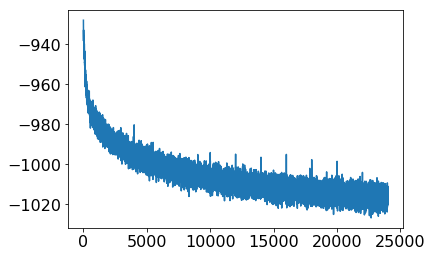

In [46]:
plt.plot(np.concatenate([h[0] for h in hists]))

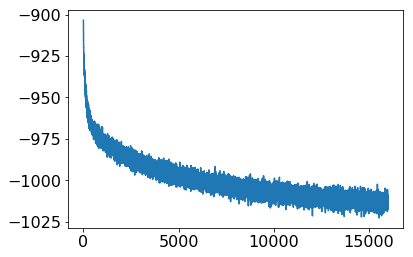

In [170]:
plt.plot(np.concatenate([h[0] for h in hists]))

In [47]:
# sample
sample_z = np.random.randn(100000, xyzflat.shape[1])
sample_x = bg.transform_zx(sample_z)

In [48]:
traj_sample = mdtraj.Trajectory(sample_x.reshape((sample_x.shape[0], -1, 3)), top_backbone)

In [49]:
view = nglview.show_mdtraj(traj_sample[:10])
view.add_representation("ball+stick", selection='atomname C N CA')
view

NGLWidget(count=10)

In [50]:
backbone_featurizer = pyemma.coordinates.featurizer(top_backbone)
backbone_featurizer.add_distances_ca()

In [51]:
dists_sample = backbone_featurizer.transform(traj_sample)

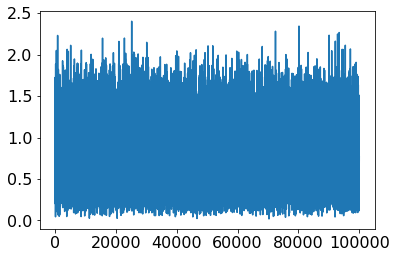

In [52]:
plt.plot(dists_sample[:, 0])

In [53]:
tics_sample = (dists_sample - tica_obj.mean).dot(tica_obj.eigenvectors)[:, :3]
#tics_sample = (dists_sample - dists_sample.mean(axis=0)).dot(tica_obj.eigenvectors)[:, :3]
tics_sample.shape
#tics_sample = tica_obj.transform(dists_sample)

(100000, 3)

(<matplotlib.figure.Figure at 0x1c1c1c5160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c1c413208>)

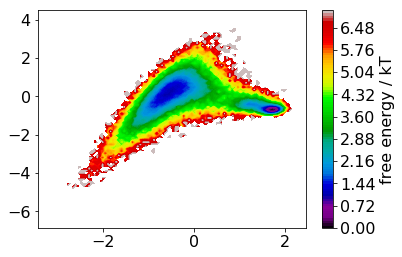

In [54]:
pyemma.plots.plot_free_energy(tics_sample[:, 0], tics_sample[:, 1])
#plt.xlim(-3, 2)
#plt.ylim(-3, 2)

(<matplotlib.figure.Figure at 0x1a95198e48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a951632e8>)

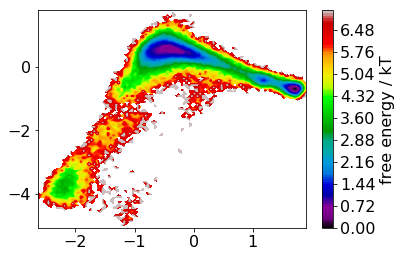

In [158]:
pyemma.plots.plot_free_energy(tics[:, 0], tics[:, 1])